# Dermatologist-AI Project: Single Network Approach
Workbook for a single network approach that classifies images into melanomas, nevus, or SBK

### Set up and process data

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from keras.applications.vgg19 import preprocess_input
from tqdm import tqdm
from PIL import ImageFile                            
import os
import pickle
ImageFile.LOAD_TRUNCATED_IMAGES = True      


# define function to load train, test, and validation datasets
def load_dataset(path, shuffle):
    data = load_files(path, shuffle=shuffle)
    file_paths = np.array(data['filenames'])
    one_hot_labels = np_utils.to_categorical(np.array(data['target']),3)
    return file_paths, one_hot_labels

# define functions to convert images into 4D tensors for convnets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

# define function to decide whether to load tensors from a saved pickle or raw images
def load_tensors_and_labels(pickle_file, raw_file_path, shuffle, force=False):
    pickle_file = os.path.join('.', pickle_file)
 
    if force or not os.path.exists(pickle_file):
        files, labels = load_dataset(raw_file_path, shuffle)
        tensors = paths_to_tensor(files).astype('float32')/255
        with open(pickle_file, 'wb') as handle:
            pickle.dump([tensors, labels], handle, protocol=pickle.HIGHEST_PROTOCOL)
        return tensors, labels

    else:        
        with open(pickle_file, 'rb') as handle:
            tensors, labels = pickle.load(handle)        
        return tensors, labels
    

Using TensorFlow backend.


In [2]:
# Load data

train_tensors, train_labels = load_tensors_and_labels('train_data.pickle','../data/train', True)
valid_tensors, valid_labels = load_tensors_and_labels('valid_data.pickle','../data/valid', True)
test_tensors, test_labels = load_tensors_and_labels('test_data.pickle','../data/test', False)

# load list of skin condition names
skin_names = [item[14:-1] for item in sorted(glob("../data/train/*/"))]


Network based on four three layers of VGG19 followed by trainable convnet and dense layers

In [39]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

#First 4 blocks of VGG19
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv1', 
                        input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block1_pool'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv1'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block2_pool'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv1'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv2'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv3'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv4'))
model.add(MaxPooling2D(pool_size=2, name='block3_pool'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv1'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv2'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv3'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv4'))
model.add(MaxPooling2D(pool_size=2, name='block4_pool'))

#First 1 trainable convnet block
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv1'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block5_pool'))
model.add(Dropout(0.5))

#Trainable dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

Import and assign VGG19 weights

In [40]:
from keras import optimizers
#opt = optimizers.rmsprop(lr=0.00001, decay=1e-6)
opt = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
from keras import applications
import h5py

weights_path = 'vgg19_weights.h5'
f = h5py.File(weights_path, 'r')

VGGnet_layers = ['block1_conv1',
                 'block1_conv2',
                 'block2_conv1',
                 'block2_conv2',
                 'block3_conv1',
                 'block3_conv2',
                 'block3_conv3',
                 'block3_conv4',
                 'block4_conv1',
                 'block4_conv2',
                 'block4_conv3',
                 'block4_conv4']
layer_names = [layer.name for layer in model.layers]

for i in VGGnet_layers:
    weight_names = f[i].attrs["weight_names"]    
    weights = [f[i][j] for j in weight_names]
    index = layer_names.index(i)
    model.layers[index].set_weights(weights)


Set up data augmentation functions

In [42]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.2, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.2, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [43]:
from keras.callbacks import ModelCheckpoint  

epochs = 200

checkpointer = ModelCheckpoint(filepath='saved_models/weights8.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(datagen_train.flow(train_tensors, train_labels, batch_size=20),
                    steps_per_epoch=train_tensors.shape[0] // 20,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_labels, batch_size=20),
                    validation_steps=valid_tensors.shape[0] // 20)

Epoch 1/200
160/160 [==============================] - 49s - loss: 1.1201 - acc: 0.5456 - val_loss: 1.1728 - val_acc: 0.5214
Epoch 2/200


160/160 [==============================] - 48s - loss: 0.8964 - acc: 0.6144 - val_loss: 1.2179 - val_acc: 0.4846
Epoch 3/200


160/160 [==============================] - 48s - loss: 0.8609 - acc: 0.6419 - val_loss: 1.1434 - val_acc: 0.5077
Epoch 4/200


160/160 [==============================] - 48s - loss: 0.8532 - acc: 0.6469 - val_loss: 1.2119 - val_acc: 0.4692
Epoch 5/200


160/160 [==============================] - 48s - loss: 0.8257 - acc: 0.6525 - val_loss: 1.0724 - val_acc: 0.5154
Epoch 6/200


160/160 [==============================] - 48s - loss: 0.8143 - acc: 0.6488 - val_loss: 1.0752 - val_acc: 0.5077
Epoch 7/200


160/160 [==============================] - 47s - loss: 0.8144 - acc: 0.6619 - val_loss: 1.1246 - val_acc: 0.5000
Epoch 8/200


160/160 [==============================] - 47s - loss: 0.8119 - acc: 0.6535 - val_loss: 1.0888 - val_acc: 0.5231
Epoch 9/200


160/160 [==============================] - 47s - loss: 0.7919 - acc: 0.6572 - val_loss: 0.9939 - val_acc: 0.5231
Epoch 10/200


160/160 [==============================] - 47s - loss: 0.7795 - acc: 0.6631 - val_loss: 1.0242 - val_acc: 0.5385
Epoch 11/200


160/160 [==============================] - 47s - loss: 0.7792 - acc: 0.6681 - val_loss: 1.0644 - val_acc: 0.5385
Epoch 12/200


160/160 [==============================] - 47s - loss: 0.7775 - acc: 0.6678 - val_loss: 0.9654 - val_acc: 0.5769
Epoch 13/200


160/160 [==============================] - 47s - loss: 0.7618 - acc: 0.6725 - val_loss: 0.9885 - val_acc: 0.5769
Epoch 14/200


160/160 [==============================] - 47s - loss: 0.7571 - acc: 0.6744 - val_loss: 0.9678 - val_acc: 0.5077
Epoch 15/200


160/160 [==============================] - 47s - loss: 0.7606 - acc: 0.6584 - val_loss: 1.0079 - val_acc: 0.4846
Epoch 16/200


160/160 [==============================] - 47s - loss: 0.7450 - acc: 0.6766 - val_loss: 1.0007 - val_acc: 0.5308
Epoch 17/200


160/160 [==============================] - 47s - loss: 0.7419 - acc: 0.6766 - val_loss: 0.9364 - val_acc: 0.5769
Epoch 18/200


160/160 [==============================] - 47s - loss: 0.7357 - acc: 0.6722 - val_loss: 0.9763 - val_acc: 0.5231
Epoch 19/200


160/160 [==============================] - 47s - loss: 0.7355 - acc: 0.6678 - val_loss: 0.9021 - val_acc: 0.6154
Epoch 20/200


160/160 [==============================] - 47s - loss: 0.7138 - acc: 0.6756 - val_loss: 1.0263 - val_acc: 0.5923
Epoch 21/200


160/160 [==============================] - 47s - loss: 0.7153 - acc: 0.6912 - val_loss: 0.9012 - val_acc: 0.5846
Epoch 22/200


160/160 [==============================] - 47s - loss: 0.7109 - acc: 0.6934 - val_loss: 0.8992 - val_acc: 0.5538
Epoch 23/200


160/160 [==============================] - 47s - loss: 0.7124 - acc: 0.6875 - val_loss: 0.8848 - val_acc: 0.5615
Epoch 24/200


160/160 [==============================] - 47s - loss: 0.7022 - acc: 0.6925 - val_loss: 0.9591 - val_acc: 0.5385
Epoch 25/200


160/160 [==============================] - 47s - loss: 0.7022 - acc: 0.6906 - val_loss: 0.8937 - val_acc: 0.6077
Epoch 26/200


160/160 [==============================] - 47s - loss: 0.7067 - acc: 0.6869 - val_loss: 0.9910 - val_acc: 0.5077
Epoch 27/200


160/160 [==============================] - 47s - loss: 0.6847 - acc: 0.6866 - val_loss: 0.8789 - val_acc: 0.5769
Epoch 28/200


160/160 [==============================] - 47s - loss: 0.6917 - acc: 0.6878 - val_loss: 0.9347 - val_acc: 0.5231
Epoch 29/200


160/160 [==============================] - 47s - loss: 0.6840 - acc: 0.7053 - val_loss: 0.9127 - val_acc: 0.5615
Epoch 30/200


160/160 [==============================] - 47s - loss: 0.6765 - acc: 0.6947 - val_loss: 0.9705 - val_acc: 0.5462
Epoch 31/200


160/160 [==============================] - 47s - loss: 0.6783 - acc: 0.7094 - val_loss: 0.9200 - val_acc: 0.5923
Epoch 32/200


160/160 [==============================] - 47s - loss: 0.6819 - acc: 0.6872 - val_loss: 0.8478 - val_acc: 0.5846
Epoch 33/200


160/160 [==============================] - 47s - loss: 0.6572 - acc: 0.7125 - val_loss: 0.8309 - val_acc: 0.6231
Epoch 34/200


160/160 [==============================] - 47s - loss: 0.6658 - acc: 0.7006 - val_loss: 0.8299 - val_acc: 0.6615
Epoch 35/200


160/160 [==============================] - 47s - loss: 0.6639 - acc: 0.7034 - val_loss: 0.8874 - val_acc: 0.5615
Epoch 36/200


160/160 [==============================] - 47s - loss: 0.6732 - acc: 0.6953 - val_loss: 0.8618 - val_acc: 0.5769
Epoch 37/200


160/160 [==============================] - 47s - loss: 0.6593 - acc: 0.7106 - val_loss: 0.8283 - val_acc: 0.6231
Epoch 38/200


160/160 [==============================] - 47s - loss: 0.6524 - acc: 0.7156 - val_loss: 0.7509 - val_acc: 0.6615
Epoch 39/200


160/160 [==============================] - 47s - loss: 0.6641 - acc: 0.7063 - val_loss: 0.7863 - val_acc: 0.6462
Epoch 40/200


160/160 [==============================] - 47s - loss: 0.6471 - acc: 0.7103 - val_loss: 0.8507 - val_acc: 0.5923
Epoch 41/200


160/160 [==============================] - 47s - loss: 0.6479 - acc: 0.7159 - val_loss: 0.8357 - val_acc: 0.6000
Epoch 42/200


160/160 [==============================] - 47s - loss: 0.6470 - acc: 0.7163 - val_loss: 0.8193 - val_acc: 0.6615
Epoch 43/200


160/160 [==============================] - 47s - loss: 0.6479 - acc: 0.7150 - val_loss: 0.8477 - val_acc: 0.6000
Epoch 44/200


160/160 [==============================] - 47s - loss: 0.6388 - acc: 0.7172 - val_loss: 0.7758 - val_acc: 0.6385
Epoch 45/200


160/160 [==============================] - 47s - loss: 0.6424 - acc: 0.7184 - val_loss: 0.7809 - val_acc: 0.6615
Epoch 46/200


160/160 [==============================] - 47s - loss: 0.6274 - acc: 0.7150 - val_loss: 0.8558 - val_acc: 0.6077
Epoch 47/200


160/160 [==============================] - 47s - loss: 0.6333 - acc: 0.7184 - val_loss: 0.8145 - val_acc: 0.6308
Epoch 48/200


160/160 [==============================] - 47s - loss: 0.6235 - acc: 0.7278 - val_loss: 0.9065 - val_acc: 0.5692
Epoch 49/200


160/160 [==============================] - 47s - loss: 0.6285 - acc: 0.7322 - val_loss: 0.7645 - val_acc: 0.6308
Epoch 50/200


160/160 [==============================] - 47s - loss: 0.6224 - acc: 0.7262 - val_loss: 0.8851 - val_acc: 0.6308
Epoch 51/200


160/160 [==============================] - 47s - loss: 0.6216 - acc: 0.7266 - val_loss: 0.7446 - val_acc: 0.7154
Epoch 52/200


160/160 [==============================] - 47s - loss: 0.6118 - acc: 0.7353 - val_loss: 0.7897 - val_acc: 0.6538
Epoch 53/200


160/160 [==============================] - 47s - loss: 0.6221 - acc: 0.7212 - val_loss: 0.7768 - val_acc: 0.6154
Epoch 54/200


160/160 [==============================] - 47s - loss: 0.5926 - acc: 0.7372 - val_loss: 0.7083 - val_acc: 0.6923
Epoch 55/200


160/160 [==============================] - 47s - loss: 0.6155 - acc: 0.7281 - val_loss: 0.8750 - val_acc: 0.6231
Epoch 56/200


160/160 [==============================] - 47s - loss: 0.6118 - acc: 0.7356 - val_loss: 0.7445 - val_acc: 0.6846
Epoch 57/200


160/160 [==============================] - 47s - loss: 0.6203 - acc: 0.7303 - val_loss: 0.7419 - val_acc: 0.6769
Epoch 58/200


160/160 [==============================] - 47s - loss: 0.6054 - acc: 0.7409 - val_loss: 0.8069 - val_acc: 0.6385
Epoch 59/200


160/160 [==============================] - 47s - loss: 0.6031 - acc: 0.7394 - val_loss: 0.8088 - val_acc: 0.6000
Epoch 60/200


160/160 [==============================] - 47s - loss: 0.5989 - acc: 0.7450 - val_loss: 0.7441 - val_acc: 0.6538
Epoch 61/200


160/160 [==============================] - 47s - loss: 0.5917 - acc: 0.7531 - val_loss: 0.7832 - val_acc: 0.6231
Epoch 62/200


160/160 [==============================] - 47s - loss: 0.6067 - acc: 0.7350 - val_loss: 0.8151 - val_acc: 0.6462
Epoch 63/200


160/160 [==============================] - 47s - loss: 0.5942 - acc: 0.7416 - val_loss: 0.9703 - val_acc: 0.5308
Epoch 64/200


160/160 [==============================] - 47s - loss: 0.5928 - acc: 0.7519 - val_loss: 0.7920 - val_acc: 0.6692
Epoch 65/200


160/160 [==============================] - 47s - loss: 0.5876 - acc: 0.7463 - val_loss: 0.7652 - val_acc: 0.6154
Epoch 66/200


160/160 [==============================] - 47s - loss: 0.5932 - acc: 0.7475 - val_loss: 0.7696 - val_acc: 0.6154
Epoch 67/200


160/160 [==============================] - 47s - loss: 0.5750 - acc: 0.7584 - val_loss: 0.7656 - val_acc: 0.7154
Epoch 68/200


160/160 [==============================] - 47s - loss: 0.5981 - acc: 0.7469 - val_loss: 0.7407 - val_acc: 0.7000
Epoch 69/200


160/160 [==============================] - 47s - loss: 0.5767 - acc: 0.7463 - val_loss: 0.7030 - val_acc: 0.7077
Epoch 70/200


160/160 [==============================] - 47s - loss: 0.5833 - acc: 0.7581 - val_loss: 0.7615 - val_acc: 0.6615
Epoch 71/200


160/160 [==============================] - 47s - loss: 0.5663 - acc: 0.7584 - val_loss: 0.7696 - val_acc: 0.6538
Epoch 72/200


160/160 [==============================] - 47s - loss: 0.5792 - acc: 0.7488 - val_loss: 0.6898 - val_acc: 0.6923
Epoch 73/200


160/160 [==============================] - 48s - loss: 0.5754 - acc: 0.7553 - val_loss: 0.6375 - val_acc: 0.7615
Epoch 74/200


160/160 [==============================] - 47s - loss: 0.5518 - acc: 0.7637 - val_loss: 0.7017 - val_acc: 0.6769
Epoch 75/200


160/160 [==============================] - 47s - loss: 0.5679 - acc: 0.7528 - val_loss: 0.7601 - val_acc: 0.6538
Epoch 76/200


160/160 [==============================] - 47s - loss: 0.5796 - acc: 0.7522 - val_loss: 0.7608 - val_acc: 0.6769
Epoch 77/200


160/160 [==============================] - 47s - loss: 0.5562 - acc: 0.7706 - val_loss: 0.7444 - val_acc: 0.6846
Epoch 78/200


160/160 [==============================] - 47s - loss: 0.5613 - acc: 0.7619 - val_loss: 0.7871 - val_acc: 0.6846
Epoch 79/200


160/160 [==============================] - 47s - loss: 0.5819 - acc: 0.7472 - val_loss: 0.6944 - val_acc: 0.6923
Epoch 80/200


160/160 [==============================] - 47s - loss: 0.5480 - acc: 0.7647 - val_loss: 0.8394 - val_acc: 0.6385
Epoch 81/200


160/160 [==============================] - 47s - loss: 0.5380 - acc: 0.7744 - val_loss: 0.7929 - val_acc: 0.6615
Epoch 82/200


160/160 [==============================] - 47s - loss: 0.5695 - acc: 0.7563 - val_loss: 0.7517 - val_acc: 0.6462
Epoch 83/200


160/160 [==============================] - 47s - loss: 0.5568 - acc: 0.7691 - val_loss: 0.7338 - val_acc: 0.6769
Epoch 84/200


160/160 [==============================] - 47s - loss: 0.5438 - acc: 0.7806 - val_loss: 0.6717 - val_acc: 0.7154
Epoch 85/200


160/160 [==============================] - 47s - loss: 0.5715 - acc: 0.7591 - val_loss: 0.6496 - val_acc: 0.7308
Epoch 86/200


160/160 [==============================] - 47s - loss: 0.5554 - acc: 0.7644 - val_loss: 0.6367 - val_acc: 0.6846
Epoch 87/200


160/160 [==============================] - 47s - loss: 0.5500 - acc: 0.7603 - val_loss: 0.6386 - val_acc: 0.7308
Epoch 88/200


160/160 [==============================] - 47s - loss: 0.5310 - acc: 0.7781 - val_loss: 0.6780 - val_acc: 0.7077
Epoch 89/200


160/160 [==============================] - 47s - loss: 0.5341 - acc: 0.7753 - val_loss: 0.7656 - val_acc: 0.6385
Epoch 90/200


160/160 [==============================] - 47s - loss: 0.5455 - acc: 0.7750 - val_loss: 0.8447 - val_acc: 0.6154
Epoch 91/200


160/160 [==============================] - 47s - loss: 0.5282 - acc: 0.7747 - val_loss: 0.6584 - val_acc: 0.7000
Epoch 92/200


160/160 [==============================] - 47s - loss: 0.5322 - acc: 0.7734 - val_loss: 0.7239 - val_acc: 0.7231
Epoch 93/200


160/160 [==============================] - 47s - loss: 0.5270 - acc: 0.7809 - val_loss: 0.7231 - val_acc: 0.7077
Epoch 94/200


160/160 [==============================] - 47s - loss: 0.5464 - acc: 0.7612 - val_loss: 0.6523 - val_acc: 0.7308
Epoch 95/200


160/160 [==============================] - 47s - loss: 0.5237 - acc: 0.7728 - val_loss: 0.8081 - val_acc: 0.6846
Epoch 96/200


160/160 [==============================] - 47s - loss: 0.5208 - acc: 0.7853 - val_loss: 0.6761 - val_acc: 0.7000
Epoch 97/200


160/160 [==============================] - 47s - loss: 0.5268 - acc: 0.7825 - val_loss: 0.6589 - val_acc: 0.7308
Epoch 98/200


160/160 [==============================] - 47s - loss: 0.5323 - acc: 0.7778 - val_loss: 0.6833 - val_acc: 0.6846
Epoch 99/200


160/160 [==============================] - 47s - loss: 0.5205 - acc: 0.7794 - val_loss: 0.7016 - val_acc: 0.7308
Epoch 100/200


160/160 [==============================] - 49s - loss: 0.5228 - acc: 0.7762 - val_loss: 0.6450 - val_acc: 0.7538
Epoch 101/200


160/160 [==============================] - 48s - loss: 0.5312 - acc: 0.7747 - val_loss: 0.6774 - val_acc: 0.7154
Epoch 102/200


160/160 [==============================] - 49s - loss: 0.5114 - acc: 0.7891 - val_loss: 0.7013 - val_acc: 0.7077
Epoch 103/200


160/160 [==============================] - 50s - loss: 0.5122 - acc: 0.7766 - val_loss: 0.7007 - val_acc: 0.6923
Epoch 104/200


160/160 [==============================] - 68s - loss: 0.5060 - acc: 0.7959 - val_loss: 0.6632 - val_acc: 0.7385
Epoch 105/200


160/160 [==============================] - 48s - loss: 0.5171 - acc: 0.7819 - val_loss: 0.5754 - val_acc: 0.7769
Epoch 106/200


160/160 [==============================] - 48s - loss: 0.5074 - acc: 0.7897 - val_loss: 0.6041 - val_acc: 0.8077
Epoch 107/200


160/160 [==============================] - 54s - loss: 0.5106 - acc: 0.7856 - val_loss: 0.6930 - val_acc: 0.7231
Epoch 108/200


160/160 [==============================] - 60s - loss: 0.4995 - acc: 0.7916 - val_loss: 0.6046 - val_acc: 0.7538
Epoch 109/200


160/160 [==============================] - 91s - loss: 0.5069 - acc: 0.7866 - val_loss: 0.6296 - val_acc: 0.7615
Epoch 110/200


160/160 [==============================] - 53s - loss: 0.5066 - acc: 0.7956 - val_loss: 0.7662 - val_acc: 0.7000
Epoch 111/200


160/160 [==============================] - 51s - loss: 0.4972 - acc: 0.7912 - val_loss: 0.8489 - val_acc: 0.6462
Epoch 112/200


160/160 [==============================] - 97s - loss: 0.4962 - acc: 0.7962 - val_loss: 0.7317 - val_acc: 0.6538
Epoch 113/200


160/160 [==============================] - 102s - loss: 0.4962 - acc: 0.8003 - val_loss: 0.6628 - val_acc: 0.7385
Epoch 114/200


160/160 [==============================] - 95s - loss: 0.4845 - acc: 0.8009 - val_loss: 0.6188 - val_acc: 0.7769
Epoch 115/200


160/160 [==============================] - 94s - loss: 0.4823 - acc: 0.7962 - val_loss: 0.6826 - val_acc: 0.7077
Epoch 116/200


160/160 [==============================] - 91s - loss: 0.4885 - acc: 0.7962 - val_loss: 0.7549 - val_acc: 0.6769
Epoch 117/200


160/160 [==============================] - 145s - loss: 0.4755 - acc: 0.8063 - val_loss: 0.8703 - val_acc: 0.6538
Epoch 118/200


160/160 [==============================] - 114s - loss: 0.4867 - acc: 0.8041 - val_loss: 0.7131 - val_acc: 0.7429
Epoch 119/200


160/160 [==============================] - 226s - loss: 0.4965 - acc: 0.7925 - val_loss: 0.6703 - val_acc: 0.7231
Epoch 120/200


160/160 [==============================] - 144s - loss: 0.4834 - acc: 0.8006 - val_loss: 0.5710 - val_acc: 0.7538
Epoch 121/200


160/160 [==============================] - 132s - loss: 0.4749 - acc: 0.8050 - val_loss: 0.6519 - val_acc: 0.7308
Epoch 122/200


160/160 [==============================] - 193s - loss: 0.4792 - acc: 0.8066 - val_loss: 0.7132 - val_acc: 0.6769
Epoch 123/200


160/160 [==============================] - 101s - loss: 0.4711 - acc: 0.8106 - val_loss: 0.7076 - val_acc: 0.7000
Epoch 124/200


160/160 [==============================] - 99s - loss: 0.4759 - acc: 0.8009 - val_loss: 0.5283 - val_acc: 0.7923
Epoch 125/200


160/160 [==============================] - 85s - loss: 0.4749 - acc: 0.8022 - val_loss: 0.7391 - val_acc: 0.7154
Epoch 126/200


160/160 [==============================] - 214s - loss: 0.4600 - acc: 0.8131 - val_loss: 0.6705 - val_acc: 0.7357
Epoch 127/200


160/160 [==============================] - 218s - loss: 0.4673 - acc: 0.8116 - val_loss: 0.6986 - val_acc: 0.7154
Epoch 128/200


160/160 [==============================] - 218s - loss: 0.4654 - acc: 0.8088 - val_loss: 0.8247 - val_acc: 0.6846
Epoch 129/200


160/160 [==============================] - 218s - loss: 0.4678 - acc: 0.8050 - val_loss: 0.6973 - val_acc: 0.7077
Epoch 130/200


160/160 [==============================] - 215s - loss: 0.4614 - acc: 0.8069 - val_loss: 0.7558 - val_acc: 0.7000
Epoch 131/200


160/160 [==============================] - 224s - loss: 0.4497 - acc: 0.8169 - val_loss: 0.6285 - val_acc: 0.7769
Epoch 132/200


160/160 [==============================] - 215s - loss: 0.4501 - acc: 0.8137 - val_loss: 0.7297 - val_acc: 0.7077
Epoch 133/200


160/160 [==============================] - 214s - loss: 0.4598 - acc: 0.8166 - val_loss: 0.6619 - val_acc: 0.7385
Epoch 134/200


160/160 [==============================] - 216s - loss: 0.4706 - acc: 0.8050 - val_loss: 0.6446 - val_acc: 0.7429
Epoch 135/200


160/160 [==============================] - 222s - loss: 0.4589 - acc: 0.8078 - val_loss: 0.6859 - val_acc: 0.7154
Epoch 136/200


160/160 [==============================] - 213s - loss: 0.4528 - acc: 0.8113 - val_loss: 0.8061 - val_acc: 0.6769
Epoch 137/200


160/160 [==============================] - 216s - loss: 0.4458 - acc: 0.8216 - val_loss: 0.6906 - val_acc: 0.7077
Epoch 138/200


160/160 [==============================] - 214s - loss: 0.4515 - acc: 0.8172 - val_loss: 0.5474 - val_acc: 0.8077
Epoch 139/200


160/160 [==============================] - 224s - loss: 0.4423 - acc: 0.8222 - val_loss: 0.6423 - val_acc: 0.7231
Epoch 140/200


160/160 [==============================] - 219s - loss: 0.4323 - acc: 0.8159 - val_loss: 0.7121 - val_acc: 0.7000
Epoch 141/200


160/160 [==============================] - 236s - loss: 0.4528 - acc: 0.8106 - val_loss: 0.6936 - val_acc: 0.6923
Epoch 142/200


160/160 [==============================] - 216s - loss: 0.4570 - acc: 0.8122 - val_loss: 0.6050 - val_acc: 0.7643
Epoch 143/200


160/160 [==============================] - 220s - loss: 0.4482 - acc: 0.8222 - val_loss: 0.6841 - val_acc: 0.7308
Epoch 144/200


160/160 [==============================] - 218s - loss: 0.4413 - acc: 0.8175 - val_loss: 0.6974 - val_acc: 0.7308
Epoch 145/200


160/160 [==============================] - 217s - loss: 0.4301 - acc: 0.8291 - val_loss: 0.7428 - val_acc: 0.7308
Epoch 146/200


160/160 [==============================] - 215s - loss: 0.4233 - acc: 0.8294 - val_loss: 0.6249 - val_acc: 0.7923
Epoch 147/200


160/160 [==============================] - 212s - loss: 0.4204 - acc: 0.8309 - val_loss: 0.8662 - val_acc: 0.6462
Epoch 148/200


160/160 [==============================] - 212s - loss: 0.4330 - acc: 0.8184 - val_loss: 0.7827 - val_acc: 0.7462
Epoch 149/200


160/160 [==============================] - 222s - loss: 0.4333 - acc: 0.8203 - val_loss: 0.8128 - val_acc: 0.6769
Epoch 150/200


160/160 [==============================] - 220s - loss: 0.4115 - acc: 0.8278 - val_loss: 0.6564 - val_acc: 0.7714
Epoch 151/200


160/160 [==============================] - 217s - loss: 0.4397 - acc: 0.8203 - val_loss: 0.6613 - val_acc: 0.7231
Epoch 152/200


160/160 [==============================] - 225s - loss: 0.4245 - acc: 0.8303 - val_loss: 0.5978 - val_acc: 0.7615
Epoch 153/200


160/160 [==============================] - 220s - loss: 0.4264 - acc: 0.8263 - val_loss: 0.8083 - val_acc: 0.6769
Epoch 154/200


160/160 [==============================] - 211s - loss: 0.4171 - acc: 0.8253 - val_loss: 0.6852 - val_acc: 0.7769
Epoch 155/200


160/160 [==============================] - 214s - loss: 0.4135 - acc: 0.8309 - val_loss: 0.7983 - val_acc: 0.7308
Epoch 156/200


160/160 [==============================] - 222s - loss: 0.4151 - acc: 0.8322 - val_loss: 0.5705 - val_acc: 0.7923
Epoch 157/200


160/160 [==============================] - 217s - loss: 0.4167 - acc: 0.8294 - val_loss: 0.6841 - val_acc: 0.7154
Epoch 158/200


160/160 [==============================] - 215s - loss: 0.3958 - acc: 0.8359 - val_loss: 0.7861 - val_acc: 0.7143
Epoch 159/200


160/160 [==============================] - 210s - loss: 0.4143 - acc: 0.8288 - val_loss: 0.7734 - val_acc: 0.7538
Epoch 160/200


160/160 [==============================] - 221s - loss: 0.4083 - acc: 0.8353 - val_loss: 0.8492 - val_acc: 0.6923
Epoch 161/200


160/160 [==============================] - 219s - loss: 0.4009 - acc: 0.8369 - val_loss: 0.7387 - val_acc: 0.7154
Epoch 162/200


160/160 [==============================] - 222s - loss: 0.4037 - acc: 0.8363 - val_loss: 0.7466 - val_acc: 0.7308
Epoch 163/200


160/160 [==============================] - 211s - loss: 0.4058 - acc: 0.8394 - val_loss: 0.7807 - val_acc: 0.6846
Epoch 164/200


160/160 [==============================] - 215s - loss: 0.4222 - acc: 0.8287 - val_loss: 0.6306 - val_acc: 0.7308
Epoch 165/200


160/160 [==============================] - 214s - loss: 0.3986 - acc: 0.8381 - val_loss: 0.6304 - val_acc: 0.7615
Epoch 166/200


160/160 [==============================] - 218s - loss: 0.4031 - acc: 0.8406 - val_loss: 0.6312 - val_acc: 0.6929
Epoch 167/200


160/160 [==============================] - 217s - loss: 0.3931 - acc: 0.8372 - val_loss: 0.6576 - val_acc: 0.7615
Epoch 168/200


160/160 [==============================] - 211s - loss: 0.3861 - acc: 0.8491 - val_loss: 0.7321 - val_acc: 0.7385
Epoch 169/200


160/160 [==============================] - 219s - loss: 0.3970 - acc: 0.8409 - val_loss: 0.5716 - val_acc: 0.7538
Epoch 170/200


160/160 [==============================] - 215s - loss: 0.4009 - acc: 0.8316 - val_loss: 0.7320 - val_acc: 0.7385
Epoch 171/200


160/160 [==============================] - 225s - loss: 0.3759 - acc: 0.8528 - val_loss: 0.5952 - val_acc: 0.7462
Epoch 172/200


160/160 [==============================] - 218s - loss: 0.3976 - acc: 0.8331 - val_loss: 0.5754 - val_acc: 0.7462
Epoch 173/200


160/160 [==============================] - 217s - loss: 0.3871 - acc: 0.8384 - val_loss: 0.7236 - val_acc: 0.7154
Epoch 174/200


160/160 [==============================] - 216s - loss: 0.3936 - acc: 0.8444 - val_loss: 0.7293 - val_acc: 0.7071
Epoch 175/200


160/160 [==============================] - 219s - loss: 0.3916 - acc: 0.8425 - val_loss: 0.6558 - val_acc: 0.7231
Epoch 176/200


160/160 [==============================] - 217s - loss: 0.3733 - acc: 0.8453 - val_loss: 0.7988 - val_acc: 0.7154
Epoch 177/200


160/160 [==============================] - 215s - loss: 0.3689 - acc: 0.8497 - val_loss: 0.6136 - val_acc: 0.7615
Epoch 178/200


160/160 [==============================] - 213s - loss: 0.3699 - acc: 0.8525 - val_loss: 0.6756 - val_acc: 0.7692
Epoch 179/200


160/160 [==============================] - 219s - loss: 0.3841 - acc: 0.8516 - val_loss: 0.7973 - val_acc: 0.7077
Epoch 180/200


160/160 [==============================] - 216s - loss: 0.3686 - acc: 0.8456 - val_loss: 0.7746 - val_acc: 0.6923
Epoch 181/200


160/160 [==============================] - 215s - loss: 0.3759 - acc: 0.8453 - val_loss: 0.7024 - val_acc: 0.7769
Epoch 182/200


160/160 [==============================] - 209s - loss: 0.3894 - acc: 0.8422 - val_loss: 0.6746 - val_acc: 0.7357
Epoch 183/200


160/160 [==============================] - 210s - loss: 0.3632 - acc: 0.8569 - val_loss: 0.7501 - val_acc: 0.6846
Epoch 184/200


160/160 [==============================] - 219s - loss: 0.3602 - acc: 0.8550 - val_loss: 0.5392 - val_acc: 0.7923
Epoch 185/200


160/160 [==============================] - 212s - loss: 0.3606 - acc: 0.8581 - val_loss: 0.7147 - val_acc: 0.7538
Epoch 186/200


160/160 [==============================] - 211s - loss: 0.3719 - acc: 0.8550 - val_loss: 0.7210 - val_acc: 0.7385
Epoch 187/200


160/160 [==============================] - 219s - loss: 0.3590 - acc: 0.8622 - val_loss: 0.6354 - val_acc: 0.7846
Epoch 188/200


160/160 [==============================] - 216s - loss: 0.3637 - acc: 0.8509 - val_loss: 0.7182 - val_acc: 0.7308
Epoch 189/200


160/160 [==============================] - 223s - loss: 0.3718 - acc: 0.8563 - val_loss: 0.7252 - val_acc: 0.7077
Epoch 190/200


160/160 [==============================] - 213s - loss: 0.3662 - acc: 0.8550 - val_loss: 0.8832 - val_acc: 0.6714
Epoch 191/200


160/160 [==============================] - 206s - loss: 0.3524 - acc: 0.8563 - val_loss: 0.7583 - val_acc: 0.7231
Epoch 192/200


160/160 [==============================] - 221s - loss: 0.3333 - acc: 0.8728 - val_loss: 0.7290 - val_acc: 0.7538
Epoch 193/200


160/160 [==============================] - 217s - loss: 0.3638 - acc: 0.8478 - val_loss: 0.7619 - val_acc: 0.6923
Epoch 194/200


160/160 [==============================] - 212s - loss: 0.3630 - acc: 0.8516 - val_loss: 0.6731 - val_acc: 0.7692
Epoch 195/200


160/160 [==============================] - 214s - loss: 0.3391 - acc: 0.8644 - val_loss: 0.6390 - val_acc: 0.7077
Epoch 196/200


160/160 [==============================] - 220s - loss: 0.3444 - acc: 0.8631 - val_loss: 0.6658 - val_acc: 0.7385
Epoch 197/200


160/160 [==============================] - 209s - loss: 0.3668 - acc: 0.8466 - val_loss: 0.7006 - val_acc: 0.7462
Epoch 198/200


160/160 [==============================] - 211s - loss: 0.3408 - acc: 0.8672 - val_loss: 0.7385 - val_acc: 0.7143
Epoch 199/200


160/160 [==============================] - 212s - loss: 0.3538 - acc: 0.8575 - val_loss: 0.7338 - val_acc: 0.7308
Epoch 200/200


160/160 [==============================] - 208s - loss: 0.3532 - acc: 0.8641 - val_loss: 0.7129 - val_acc: 0.7538


## Create output .csv for testing

In [44]:
# Load the model weights with the best validation loss.

model.load_weights('saved_models/weights8.hdf5')

In [45]:
import pandas as pd

y_pred = pd.DataFrame(columns=["task_1", "task_2"])

for ii in tqdm(range(len(test_labels))):
    #path = test_files[ii]
    probability = model.predict(np.expand_dims(test_tensors[ii], axis=0))
    prediction = np.argmax(probability)
    ground_truth = test_labels[ii]    
    y_pred.loc[ii] = [0, 0]
    #print(prediction)
    #print(prediction == 0)
    if prediction == 0:
        y_pred.loc[ii]['task_1'] = 1
        #print("melanoma detected at row ",ii)
    if prediction == 2:
        y_pred.loc[ii]['task_2'] = 1
    
    
y_pred.to_csv("prediction3.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:12<00:00, 47.82it/s]


## Internal testing vs. ground truths

In [46]:
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

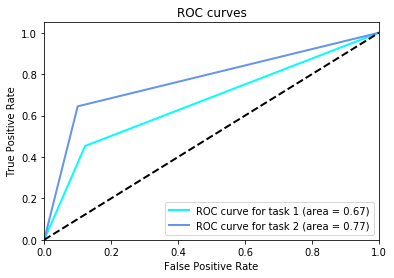

Category 1 Score: 0.665
Category 2 Score: 0.772
Category 3 Score: 0.719


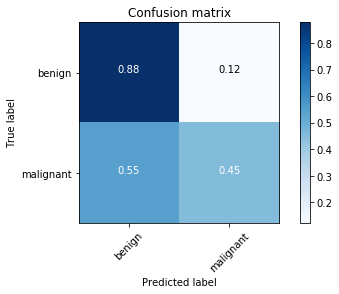

In [47]:
preds_path = sys.argv[1]
thresh = 0.25

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv("prediction3.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
